In [7]:
import csv
import numpy as np
import utils
import hrr_utils
import time
import scipy
import random

from sklearn import linear_model
from sklearn.kernel_ridge import KernelRidge
from sklearn.linear_model import SGDRegressor
from matplotlib import pyplot as plt
from matplotlib.collections import LineCollection
%matplotlib inline 

plt.rcParams.update({'axes.titlesize': 'xx-large'})
plt.rcParams.update({'axes.labelsize': 'xx-large'})
plt.rcParams.update({'xtick.labelsize': 'x-large', 'ytick.labelsize': 'x-large'})
plt.rcParams.update({'legend.fontsize': 'x-large'})
plt.rcParams.update({'text.usetex': True})

In [1]:
N=1000

def genX(verbs, indices):
    X = np.zeros((len(verbs), N)) # Exclusively difference PAST1-PRES1
    PRES1 = np.zeros((len(verbs), N))
    PRES2 = np.zeros((len(verbs), N))
    PAST1 = np.zeros((len(verbs), N))
    PAST2 = np.zeros((len(verbs), N))
    
    for m in range(len(indices)):
        pair = verbs[indices[m]]
        past1 = hrr_utils.GetRVClipHash(pair[1], dic1, 3)
        past2 = hrr_utils.GetRVClipHash(pair[1], dic2, 3)
        pres1 = hrr_utils.GetRVClipHash(pair[0], dic1, 3)
        pres2 = hrr_utils.GetRVClipHash(pair[0], dic2, 3)
        PRES1[m] = pres1
        PRES2[m] = pres2
        PAST1[m] = past1
        PAST2[m] = past2

    #X = np.where(PAST1-PRES1 > 0, 1, -1)
    X = PAST1-PRES1
    return X, PRES1, PRES2, PAST1, PAST2


def closed_train(Past, Present):
    return np.dot(np.linalg.pinv(Present,rcond=5e-2), Past)

def loss(W, X_train, y_train, lnum=1):
    lost = norm(np.dot(X_train,W) - y_train, lnum)
    return lost

def train(X_train, y_train, reg=0):
    ''' Build a model from X_train -> y_train '''
    xtx = X_train.T.dot(X_train)
    return scipy.linalg.solve(xtx + reg*np.eye(xtx.shape[0]), X_train.T.dot(y_train), sym_pos=True)

# no regularization yet
def train_gd(X_train, y_train, model, alpha=0.1, reg=0):
    ''' Build a model from X_train -> y_train using batch gradient descent 
        Gradient update equation: W = W.T(X.TX) - y.TX + 2alphaW.T
    '''
    
    gradient = 2*np.dot(model.T, np.dot(X_train.T,X_train))
    gradient -= 2*np.dot(y_train.T,X_train)
    gradient += 2*reg*model.T
    gradient = gradient.T/X_train.shape[0]
    model = model - alpha * gradient
    return model

def train_sgd(X_train, y_train, model, i, alpha=0.1, reg=0):
    ''' Build a model from X_train -> y_train using stochastic gradient descent 
        Gradient update equation: W = W.T(X[i].TX[i]) - y[i].TX[i] + 2alphaW.T
    '''
    #i = int(np.random.uniform(low=0,high=X_train.shape[0]))
    gradient = 2*np.dot(model.T, np.outer(X_train[i,:].T, X_train[i,:]))
    gradient -= 2*np.outer(y_train[i,:].T, X_train[i,:].T)
    gradient += 2*reg*model.T
    gradient = gradient.T/X_train.shape[0]
    model += model - alpha * gradient
    
    return model

def predict(model, X):
    ''' From model and data points, output prediction vectors '''
    return X.dot(model)

def sim(x, y):
    if len(x.shape) == 1 or len(y.shape)==1:
        return np.dot(x, y)
    return np.sum(np.multiply(x, y), axis=1)

def round_to_tick(number):
    """Round a number to the closest half integer."""
    return round(number * 2) / 2

def graph(x, y1, y2, y1std, y2std, title=None, xlabel='number of words', ylabel='average dot product', legend='upper left'):   
    fig = plt.figure(figsize=(4,3))
    plt.tick_params(axis='both', which='major', labelsize=12)
    plt.tick_params(axis='both', which='minor', labelsize=12)
    plt.xticks(np.arange(0, 1701, 400))
    
    start = round_to_tick(min(min(y1), min(y2)) - max(max(y1std),max(y2std)))
    end = round_to_tick(max(max(y1), max(y2)) + max(max(y1std),max(y2std)))
    
    plt.yticks(np.arange(start-.5, end+.5, .5))
    plt.plot([0, 1700], [0, 0], 'k')

    plt.plot(x, y1, c='b', lw=2, label='Train')
    plt.plot(x, y2, c='g', lw=2, label='Test')

    plt.fill_between(x, y1-y1std, y1+y1std, facecolor='b', alpha=0.1)
    plt.fill_between(x, y2-y2std, y2+y2std, facecolor='g', alpha=0.1)

    plt.legend(loc=legend,fontsize=12)

    plt.xlabel('Number Training Examples',fontsize=16)
    plt.ylabel('Feature Similarity',fontsize=16)
    plt.title(title,fontsize=16)

    plt.xlim([0, 1700])

    plt.tight_layout()
# https://matplotlib.org/api/lines_api.html
def graph_separate(x, y1, y2, y1std, y2std, \
                   y1irregular, y2irregular, \
                   title=None, xlabel='number of words', ylabel='average dot product', legend='upper left'):   

    fig = plt.figure(figsize=(4,3))
    plt.tick_params(axis='both', which='major', labelsize=12)
    plt.tick_params(axis='both', which='minor', labelsize=12)
    plt.xticks(np.arange(0, 1701, 400))
    start = round_to_tick(min(min(y1), min(y2)) - max(max(y1std),max(y2std)))
    end = round_to_tick(max(max(y1), max(y2)) + max(max(y1std),max(y2std)))
    
    plt.yticks(np.arange(start-.5, end+.5, .5))
    plt.plot([0, 1700], [0, 0], 'k')

    plt.plot(x, y1, c='b', lw=2, label='Train')
    plt.plot(x, y2, c='g', lw=2, label='Test')
    plt.plot(x, y1irregular, ':', c='b', lw=2, label='Train')
    plt.plot(x, y2irregular, ':', c='g', lw=2, label='Test')

    plt.fill_between(x, y1-y1std, y1+y1std, facecolor='b', alpha=0.1)
    plt.fill_between(x, y2-y2std, y2+y2std, facecolor='g', alpha=0.1)

    plt.legend(loc=legend,fontsize=12)

    plt.xlabel('Number Training Examples',fontsize=16)
    plt.ylabel('Feature Similarity',fontsize=16)
    plt.title(title,fontsize=16)

    plt.xlim([0, 1700])

    plt.tight_layout()

In [2]:
reg_pres, reg_past, reg_freq = utils.GetRegularVerbs(frequency=1)
irreg_pres, irreg_past, irreg_freq = utils.GetIrregularVerbs(frequency=1)


regular = zip(reg_pres, reg_past, reg_freq)
irregular = zip(irreg_pres, irreg_past, irreg_freq)

train_frac = 2/3.0

irregular_train_idx = int(train_frac*len(irreg_pres))
train_irreg = irregular[0:irregular_train_idx]

regular_train_idx = 1700 - len(train_irreg) 
train_reg = regular[0:regular_train_idx]

test_reg = regular[regular_train_idx:]
test_irreg = irregular[irregular_train_idx:]

dic1 = hrr_utils.GenerateDefaultDictionary(N)
dic2 = hrr_utils.GenerateDefaultDictionary(N)

train_all = train_reg + train_irreg
test_all = test_reg + test_irreg

train_all_indices = [i for i in range(len(train_all))]
test_all_indices = [i for i in range(len(test_all))]
random.shuffle(train_all_indices)
random.shuffle(test_all_indices)

In [3]:
trainX, trainpres1, trainpres2, trainpast1, trainpast2 = genX(train_all,train_all_indices)
testX, testpres1, testpres2, testpast1, testpast2 = genX(test_all, test_all_indices)

In [4]:
# first tried correlation matrix of X, X
def online_regression(Past, Present, reg=1):
    corr = np.linalg.inv(np.outer(Present, Present) + reg*np.eye(N))
    return corr * np.outer(Present, Past)

# try correlation matrix of W, W instead?
def online_regression_covW(W, Past, Present, reg=1):
    corr = np.linalg.inv(W.dot(W.T) + reg*np.eye(N))
    return corr * np.outer(Present, Past)

def online_regression_covWX(W, Past, Present, reg=1):
    pred = Present.dot(W)
    corr = np.linalg.inv(np.outer(pred, Present) + reg*np.eye(N))
    return corr * np.outer(Present, Past)

figures/online_regression-regularized_trigam-N=1000-W=1889-reg=1-170429


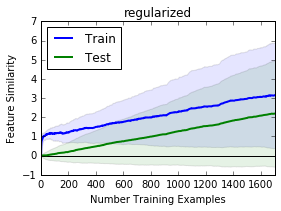

In [17]:
W = np.zeros((N,N))

x = np.arange(1, trainpres1.shape[0], 1)
y1 = np.zeros(x.shape[0])
y2 = np.zeros(x.shape[0])
y1std = np.zeros(x.shape[0])
y2std = np.zeros(x.shape[0])
reg = 1

y1irregular = np.zeros(x.shape[0])
y2irregular = np.zeros(x.shape[0])

sim2indices = [j for j in range(testpres1.shape[0]) if test_all_indices[j] >= len(test_reg)]

for i in range(x.shape[0]):#trainpres1.shape[0]):
    k = x[i]
    
    train_pred = trainpres1[:k].dot(W)
    test_pred = testpres1.dot(W)

    sim1 = sim(train_pred, trainpast2[:k])
    sim2 = sim(test_pred, testpast2)
    
    sim1indices = [j for j in range(sim1.shape[0]) if train_all_indices[j] >= len(train_reg)]

    irregularsim1 = sim1[sim1indices]
    irregularsim2 = sim2[sim2indices]
    
    y1[i] = sim1.mean()/N
    y1std[i] = np.nanstd(sim1, axis=0)/N
    y2[i] = sim2.mean()/N
    y2std[i] = np.nanstd(sim2, axis=0)/N
    
    y1irregular[i] = irregularsim1.mean()/N
    y2irregular[i] = irregularsim2.mean()/N
    
    W += online_regression(trainpast2[k], trainpres1[k])
    
graph(x,y1,y2,y1std,y2std,title='regularized',legend='upper left')

fname =  ('figures/online_regression-regularized_trigam-N=' + str(N)
          + '-W=' + str(len(trainpres1)) + "-reg=" + str(reg)
          + '-' + time.strftime('%y%m%d'))
print fname

plt.savefig(fname + '.png', transparent=True)
plt.savefig(fname + '.eps', transparent=True)

In [ ]:
graph_separate(x, y1, y2, y1std, y2std, \
                   y1irregular, y2irregular, \
                   title="regularized",legend="upper left") 

fname =  ('figures/online_regression-separate-regularized_trigam-N=' + str(N)
          + '-W=' + str(len(trainpres1)) + "-reg=" + str(reg)
          + '-' + time.strftime('%y%m%d'))
print fname

plt.savefig(fname + '.png', transparent=True)
plt.savefig(fname + '.eps', transparent=True)

figures/online_regressionW-regularized_trigam-N=1000-W=1700-reg=1-170503


/Users/quinntran/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:34: RuntimeWarning: Mean of empty slice.
/Users/quinntran/anaconda/lib/python2.7/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


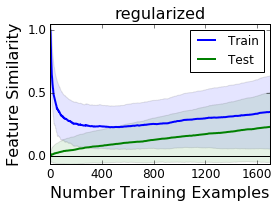

In [5]:
W = online_regression(trainpast2[0], trainpres1[0])

x = np.arange(1, trainpres1.shape[0], 1)
y1 = np.zeros(x.shape[0])
y2 = np.zeros(x.shape[0])
y1std = np.zeros(x.shape[0])
y2std = np.zeros(x.shape[0])
reg = 1

y1irregular = np.zeros(x.shape[0])
y2irregular = np.zeros(x.shape[0])

sim2indices = [j for j in range(testpres1.shape[0]) if test_all_indices[j] >= len(test_reg)]

for i in range(x.shape[0]):#trainpres1.shape[0]):
    k = x[i]
    
    train_pred = trainpres1[:k].dot(W)
    test_pred = testpres1.dot(W)

    sim1 = sim(train_pred, trainpast2[:k])
    sim2 = sim(test_pred, testpast2)

    sim1indices = [j for j in range(sim1.shape[0]) if train_all_indices[j] >= len(train_reg)]

    irregularsim1 = sim1[sim1indices]
    irregularsim2 = sim2[sim2indices]
    
    y1[i] = sim1.mean()/N
    y1std[i] = np.nanstd(sim1, axis=0)/N
    y2[i] = sim2.mean()/N
    y2std[i] = np.nanstd(sim2, axis=0)/N
    
    y1irregular[i] = irregularsim1.mean()/N
    y2irregular[i] = irregularsim2.mean()/N
    
        
    W += online_regression_covW(W, trainpast2[k], trainpres1[k])

graph(x,y1,y2,y1std,y2std,title='regularized',legend='upper right')

fname =  ('figures/online_regressionW-regularized_trigam-N=' + str(N)
          + '-W=' + str(len(trainpres1)) + "-reg=" + str(reg)
          + '-' + time.strftime('%y%m%d'))
print fname

plt.savefig(fname + '.png', transparent=True)
plt.savefig(fname + '.eps', transparent=True)

figures/online_regressionW-regularized_trigam-N=1000-W=1889-reg=1-170429


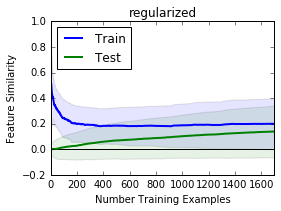

In [16]:
graph_separate(x, y1, y2, y1std, y2std, \
                   y1irregular, y2irregular, \
                   title="regularized",legend="upper left")  

fname =  ('figures/online_regressionW-separate-regularized_trigam-N=' + str(N)
          + '-W=' + str(len(trainpres1)) + "-reg=" + str(reg)
          + '-' + time.strftime('%y%m%d'))
print fname

plt.savefig(fname + '.png', transparent=True)
plt.savefig(fname + '.eps', transparent=True)

figures/online_regressionWX-regularized_trigam_regression-N=1000-W=1889-reg=1-170429


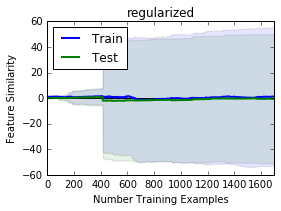

In [21]:
W = online_regression(trainpast2[0], trainpres1[0])

x = np.arange(1, trainpres1.shape[0], 1)
y1 = np.zeros(x.shape[0])
y2 = np.zeros(x.shape[0])
y1std = np.zeros(x.shape[0])
y2std = np.zeros(x.shape[0])
reg = 1

y1irregular = np.zeros(x.shape[0])
y2irregular = np.zeros(x.shape[0])

sim2indices = [j for j in range(testpres1.shape[0]) if test_all_indices[j] >= len(test_reg)]

for i in range(x.shape[0]):#trainpres1.shape[0]):
    k = x[i]
    
    train_pred = trainpres1[:k].dot(W)
    test_pred = testpres1.dot(W)

    sim1 = sim(train_pred, trainpast2[:k])
    sim2 = sim(test_pred, testpast2)
    
    sim1indices = [j for j in range(sim1.shape[0]) if train_all_indices[j] >= len(train_reg)]

    irregularsim1 = sim1[sim1indices]
    irregularsim2 = sim2[sim2indices]
    
    y1[i] = sim1.mean()/N
    y1std[i] = np.nanstd(sim1, axis=0)/N
    y2[i] = sim2.mean()/N
    y2std[i] = np.nanstd(sim2, axis=0)/N
    
    y1irregular[i] = irregularsim1.mean()/N
    y2irregular[i] = irregularsim2.mean()/N
    
    
    W += online_regression_covWX(W, trainpast2[k], trainpres1[k])
    
graph(x,y1,y2,y1std,y2std,title='regularized',legend='upper left')

fname =  ('figures/online_regressionWX-regularized_trigam_regression-N=' + str(N)
          + '-W=' + str(len(trainpres1)) + "-reg=" + str(reg)
          + '-' + time.strftime('%y%m%d'))
print fname

plt.savefig(fname + '.png', transparent=True)
plt.savefig(fname + '.eps', transparent=True)

In [ ]:
graph_separate(x, y1, y2, y1std, y2std, \
                   y1irregular, y2irregular, \
                   title="regularized",legend="upper left")  

fname =  ('figures/online_regressionWX-separate-regularized_trigam_regression-N=' + str(N)
          + '-W=' + str(len(trainpres1)) + "-reg=" + str(reg)
          + '-' + time.strftime('%y%m%d'))
print fname

plt.savefig(fname + '.png', transparent=True)
plt.savefig(fname + '.eps', transparent=True)

In [23]:
alpha=1e-3
kernels = ["linear", "laplacian", "polynomial", "sigmoid"]
clf = KernelRidge(alpha=alpha,kernel="polynomial")
# KernelRidge(alpha=1.0, coef0=1, degree=3, gamma=None, kernel='linear', kernel_params=None)

for ad in range(1):
    alpha += ad*1e-3
    x = np.arange(1, trainpres1.shape[0], 50)
    y1 = np.zeros(x.shape[0])
    y2 = np.zeros(x.shape[0])
    y1std = np.zeros(x.shape[0])
    y2std = np.zeros(x.shape[0])
    
    y1irregular = np.zeros(x.shape[0])
    y2irregular = np.zeros(x.shape[0])

    sim2indices = [j for j in range(testpres1.shape[0]) if test_all_indices[j] >= len(test_reg)]


    for i in range(x.shape[0]):
        k = x[i]
        
        clf.fit(trainpres1[:k], trainpast2[:k]) 
        
        train_pred = clf.predict(trainpres1[:k])
        test_pred = clf.predict(testpres1)

        sim1 = sim(train_pred, trainpast2[:k])
        sim2 = sim(test_pred, testpast2)
        
        sim1indices = [j for j in range(sim1.shape[0]) if train_all_indices[j] >= len(train_reg)]

        irregularsim1 = sim1[sim1indices]
        irregularsim2 = sim2[sim2indices]

        y1[i] = sim1.mean()/N
        y1std[i] = np.nanstd(sim1, axis=0)/N
        y2[i] = sim2.mean()/N
        y2std[i] = np.nanstd(sim2, axis=0)/N

        y1irregular[i] = irregularsim1.mean()/N
        y2irregular[i] = irregularsim2.mean()/N
    

    graph(x,y1,y2,y1std,y2std,title='ridge_regression_alpha='+str(alpha), legend='lower right')    

    fname =  ('figures/online-regression-kernel_ridge_regression_trigam-N=' + str(N) 
              + '-W=' + str(len(trainpres1))
              + '-alpha=' + str(alpha)
              + '-' + time.strftime('%y%m%d'))
    print fname

    plt.savefig(fname + '.png', transparent=True)
    plt.savefig(fname + '.eps', transparent=True)
    
    graph_separate(x, y1, y2, y1std, y2std, \
                   y1irregular, y2irregular, \
                   title='ridge_regression_alpha='+str(alpha),legend='lower right')     

    fname =  ('figures/online-regression-seperate-kernel_ridge_regression_trigam-N=' + str(N) 
              + '-W=' + str(len(trainpres1))
              + '-alpha=' + str(alpha)
              + '-' + time.strftime('%y%m%d'))
    print fname

    plt.savefig(fname + '.png', transparent=True)
    plt.savefig(fname + '.eps', transparent=True)

TypeError: graph() got multiple values for keyword argument 'title'

In [7]:
# alternative idea: add leastsquares soln by getting singular values from the soln. bc the directions will be generalized?
# online svd where the singular values is the regularization. u, v are the binding
# seems like another iteration of the paper then. another time....
# def pcaw_train(past, present, num_pc=20):
#     pp_pair = np.multiply(past, present)
#     tst = time.time()
#     pp_u, pp_s, pp_v = np.linalg.svd(pp_pair)
#     #print 'Elapsed: ', time.time() - tst
    
#     cidx = min(num_pc, pp_u.shape[1])
#     return np.dot(pp_u[:, :cidx], pp_v[:cidx, :]).sum(axis=0)

# def regression_train(past, present):
#     w = np.linalg.lstsq(present, past)[0]
#     return w



Stochastic gradient descent


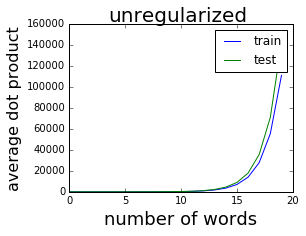

figures/unregularized_trigam_regression-170409


In [43]:
p = N
p_var = 0.015
alpha=1e-3
reg=0.1

x = np.arange(1, trainpres1.shape[0], 1)
x = np.arange(0, num_iter, 1)
y1 = np.zeros(x.shape[0])
y2 = np.zeros(x.shape[0])

print("Stochastic gradient descent")
W = np.zeros((N,N))
for i in range(x.shape[0]):
    k = x[i]
    W = train_sgd(trainpres1, trainpast2, W, i, alpha, reg)
    train_pred = predict(W, trainpres1)
    test_pred = predict(W, testpres1)
    
    
    y1[i] = sim(train_pred, trainpast2).mean()
    y2[i] = sim(test_pred, testpast2).mean()
    
    
graph(x,y1,y2,title='unregularized',legend='upper right')

fname =  ('figures/unregularized_trigam_regression') + '-' + time.strftime('%y%m%d')
print fname

plt.savefig(fname + '.png', transparent=True)
plt.savefig(fname + '.eps', transparent=True)

Batch gradient descent


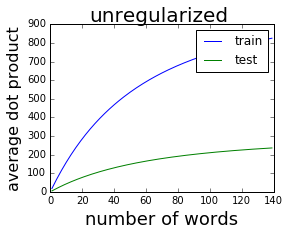

figures/unregularized_trigam_regression-170409


In [47]:
p = N
p_var = 0.015
alpha=1e-3
reg=0.1

x = np.arange(1, trainpres1.shape[0], 1)
y1 = np.zeros(x.shape[0])
y2 = np.zeros(x.shape[0])

print("Batch gradient descent")
W = np.zeros((N,N))
for i in range(x.shape[0]):
    k = x[i]
    W = train_gd(trainpres1, trainpast2, W, alpha, reg)
    train_pred = predict(W, trainpres1)
    test_pred = predict(W, testpres1)
    
    
    y1[i] = sim(train_pred, trainpast2).mean()
    y2[i] = sim(test_pred, testpast2).mean()
    
    
graph(x,y1,y2,title='unregularized',legend='upper right')

fname =  ('figures/unregularized_trigam_regression') + '-' + time.strftime('%y%m%d')
print fname

plt.savefig(fname + '.png', transparent=True)
plt.savefig(fname + '.eps', transparent=True)